# Anomaly detection in time series

The core functionality of ``dtaianomaly`` is to offer a simple interface for time series anomaly detection. Below, we illustrate how anomalies can be detected in time series using ``dtaianomaly``.


In [1]:
import matplotlib.pyplot as plt
from dtaianomaly.data import demonstration_time_series
from dtaianomaly.visualization import plot_time_series_colored_by_score, plot_time_series_anomalies
from dtaianomaly.preprocessing import MovingAverage
from dtaianomaly.anomaly_detection import MatrixProfileDetector
from dtaianomaly.pipeline import Pipeline
from dtaianomaly.thresholding import FixedCutoff
from dtaianomaly.evaluation import Precision, Recall, FBeta, AreaUnderROC, AreaUnderPR, ThresholdMetric

## Load and plot the data

We will illustrate how to detect anomalies with ``dtaianomaly`` using the demonstration time series. This time series can easily be loaded using the ``demonstration_time_series`` method and then plotted using the ``plot_time_series_colored_by_score`` method.

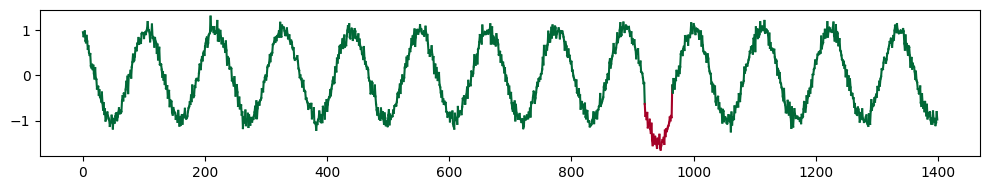

In [2]:
X, y = demonstration_time_series()
fig = plot_time_series_colored_by_score(X, y, figsize=(10, 2))
fig.tight_layout()
fig.savefig('Demonstration-time-series.svg')

## Anomaly detection

Before detecting anomalies, we can preprocess the time series. In this case, we apply ``MovingAverage`` to remove some of the noise from the time series. 

In [3]:
preprocessor = MovingAverage(window_size=10)

In general, [any anomaly detector](https://dtaianomaly.readthedocs.io/en/stable/getting_started/anomaly_detection.html) in ``dtaianomaly`` can be used to detect anomalies in this time series. Here, we use the ``MatrixProfileDetector``.

In [4]:
detector = MatrixProfileDetector(window_size=100)

Now that the components have been initialized, we can preprocess the time series and detect anomalies. Note that the preprocessor returns two values, processed data ``X_`` and processed ground truth ``y_``. While ``MovingAverage``] does not process the ground truth, other preprocessors may change the ground truth slightly. For example, ``SamplingRateUnderSampler`` samples both the time series ``X`` and labels ``y``. 

In [5]:
X_, y_ = preprocessor.fit_transform(X)
y_pred = detector.fit(X_).predict_proba(X_)

Below, we plot the time series again, as well as the predicted anomaly scores, and see that the predictions nicely align with the anomaly!

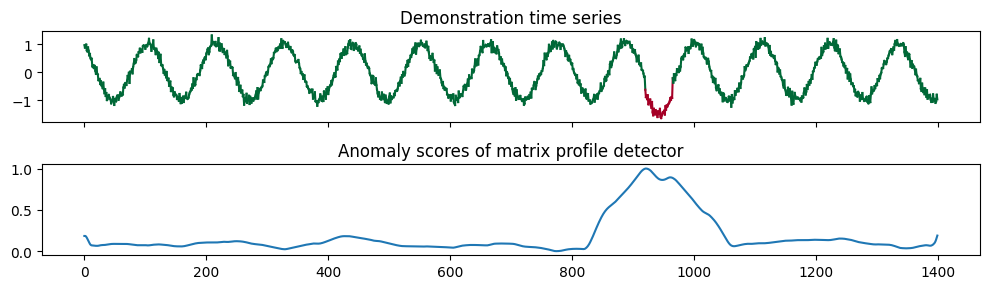

In [6]:
fig, (ax_data, ax_pred) = plt.subplots(figsize=(10, 3), nrows=2, ncols=1, sharex=True)

ax_data.set_title('Demonstration time series')
plot_time_series_colored_by_score(X, y, ax=ax_data)

ax_pred.set_title('Anomaly scores of matrix profile detector')
ax_pred.plot(y_pred)

fig.tight_layout()
fig.savefig('Demonstration-time-series-detected-anomalies.svg')

Instead of directly analyzing time series predictions and thresholds manually, the `plot_time_series_anomalies` function provides an intuitive way to visualize anomalies in a time series. This function identifies **True Positives (TP)**, **False Positives (FP)**, and **False Negatives (FN)**.

Below, we apply this function to binary real time series and corresponding predictions. The fixed cutoff threshold used for converting continuous prediction values into binary values is calculated using the``FixedCutoff`` method.


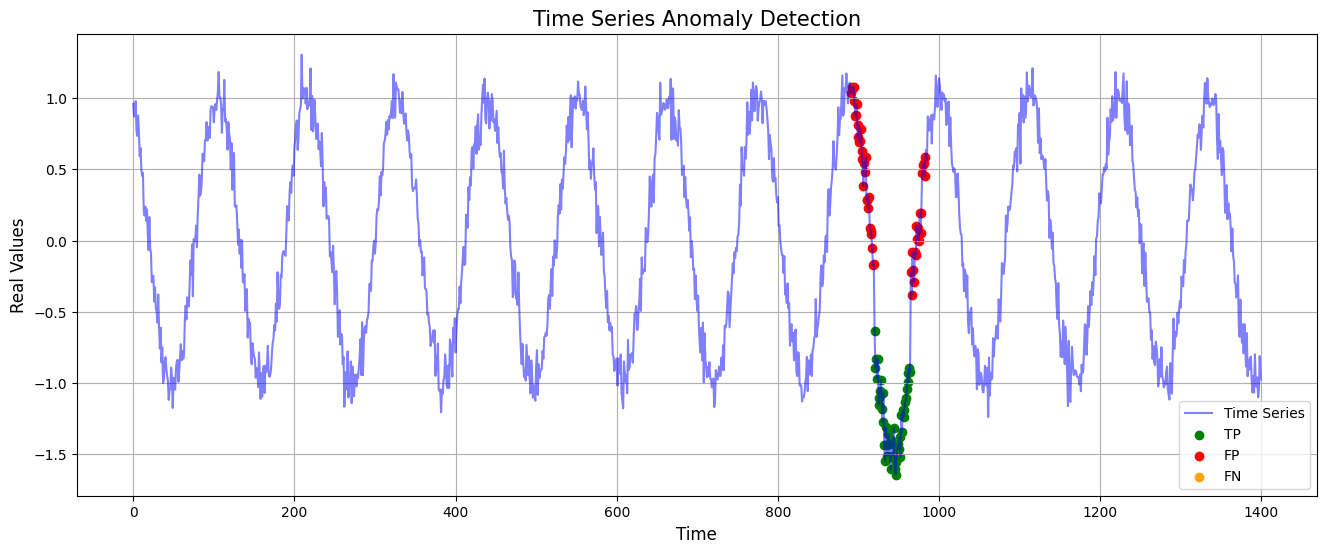

In [7]:
y_pred_binary = FixedCutoff(cutoff=0.75).threshold(y_pred)

fig, ax = plt.subplots(figsize=(16, 6))
plot_time_series_anomalies(X, y, y_pred_binary, ax=ax)
fig.savefig('Demonstration-time-series-anomalies-detailed.svg')

## Anomaly detection with a Pipeline

Above, we manually preprocessed the data and detected anomalies within the processed data. In ``dtaianomaly``, these steps can be performed automatically using a ``Pipeline``. Upon initialization, we simply pass the preprocessors we want to apply, as well as the detector. The fit and predict methods will automatically process the data before detecting anomalies. Note that it is also possible to pass a list of preprocessors to apply multiple preprocessing steps before detecting anomalies.

In [8]:
pipeline = Pipeline(
    preprocessor=preprocessor,
    detector=detector
)
y_pred = pipeline.fit(X).predict_proba(X)

## Quantitative evaluation

Besides visually checking the performance of an anomaly detector, it is also important to quantitatively measure how accurately the anomalies are detected. Below, we first compute the ``Precision`` and ``Recall``. However, that the precision and recall require binary labels, while the predicted anomaly scores are continuous. For this reason, we apply ``FixedCutoff`` thresholding to convert all scores above 0.85 to 1 ("anomaly") and the scores below 0.85 to 0 ("normal"). At this threshold, we see that all anomalous observations are detected (recall=1.0), at the cost of some false positives near the borders of the ground truth anomaly (precision<1).

In [9]:
thresholding = FixedCutoff(0.85)
y_pred_binary = thresholding.threshold(y_pred)
print('Precision:', Precision().compute(y, y_pred_binary))
print('Recall:', Recall().compute(y, y_pred_binary))

Precision: 0.6428571428571429
Recall: 1.0


Alternatively to manually applying a threshold to convert the continuous scores to binary predictions, you can initialize a ``ThresholdMetric``, which will automatically apply a specified thresholding strategy before using a binary evaluation metric. Below, we use the same thresholding as above, but compute the ``FBeta`` score with $\beta=1$. 

In [10]:
print('F1:', ThresholdMetric(thresholding, FBeta(1.0)).compute(y, y_pred))

F1: 0.782608695652174


Lastly, we also compute the ``AreaUnderROC`` and ``AreaUnderPR``. Because these metrics create a curve for all possible thresholds, we can simply pass the predicted, continuous anomaly scores, as shown below. 

In [11]:
print('AUC-ROC:', AreaUnderROC().compute(y, y_pred))
print('AUC-PR:', AreaUnderPR().compute(y, y_pred))

AUC-ROC: 0.9906683066830668
AUC-PR: 0.675234764508092
